In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
## defining sample function to be used in the code

#fx= x^3-4x^2+10x+100 fx'=3x^2-8x+10 (27-24+10) m=13; here b^2−4ac < 0 which implies slope can never be negative. if b^2−4ac = 0 the slopt intercepts x at one place, if greather than 0 then at 2 places.
def f(x):
    return x**3-4*x**2+10*x+100

f(3)

121

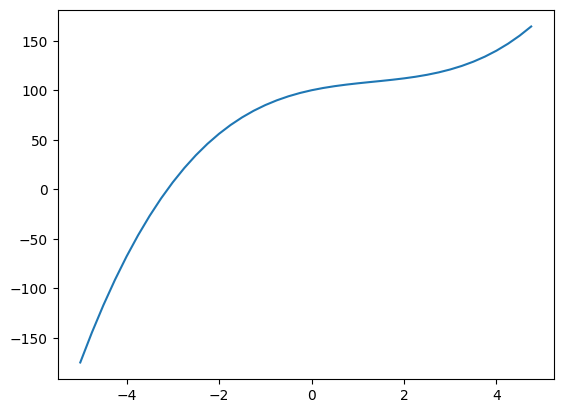

In [ ]:
## plotting graph to see slope

xs = np.arange(-5,5,0.25)
ys = f(xs)

plt.plot(xs,ys)

In [5]:
## running a basic derivative calculation

h = 0.001
x = -300
(f(x+h)-f(x))/h

272409.09599885345

In [6]:
## code for visualizing equation/neuron

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [32]:
## base micrograd class

class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self.grad=0
        self._backward = lambda: None
           
    
    def __repr__(self):
        return f"Value: data({self.data})"
        
    def __add__(self, others):
        out = Value(self.data+others.data, (self,others),'+')
        
        def _backward():
            self.grad = 1*out.grad
            others.grad = 1*out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,others):
        out = Value(self.data*others.data, (self,others),'*')
        
        def _backward():
            self.grad = others.data*out.grad
            others.grad = self.data*out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out= Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1-t**2)*out.grad
        
        out._backward = _backward
        return out


Value: data(-8.0)

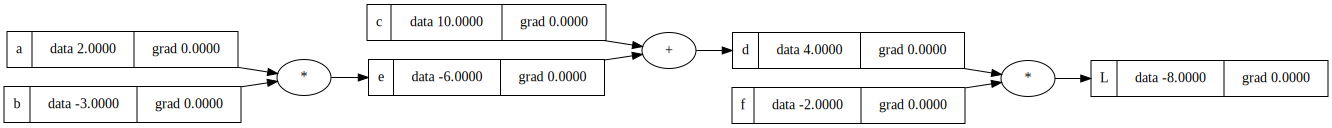

In [33]:
## example 1
        
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

draw_dot(L)

In [36]:
## using a single neuron and backpropagating through it.

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.881373358870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w1 = x1w1 + x2w2; x1w1x2w1.label = 'x1w1x2w1'
n = x1w1x2w1 + b; n.label = 'n'
o=n.tanh(); o.label = 'o'

In [ ]:
## Manual Backward pass

o.grad=1
n.grad = 1 - o.data**2 # tanh'(x) = 1 - tanh^2(x)
x1w1x2w1.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w1.grad
x2w2.grad = x1w1x2w1.grad
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

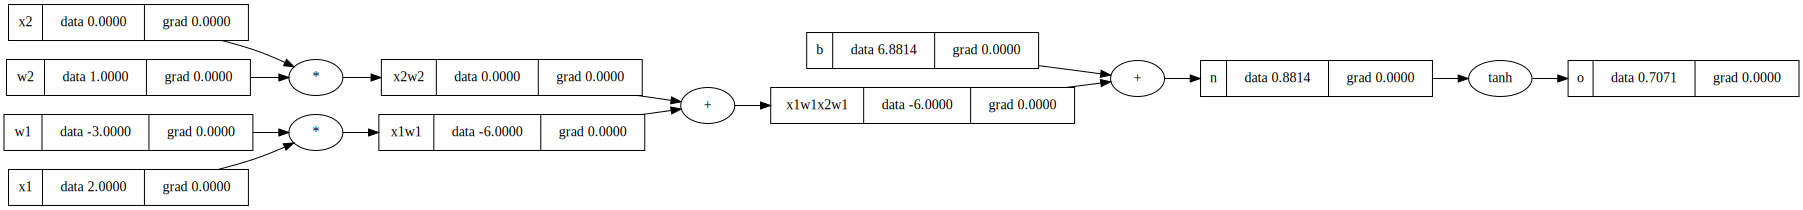

In [37]:
draw_dot(o)

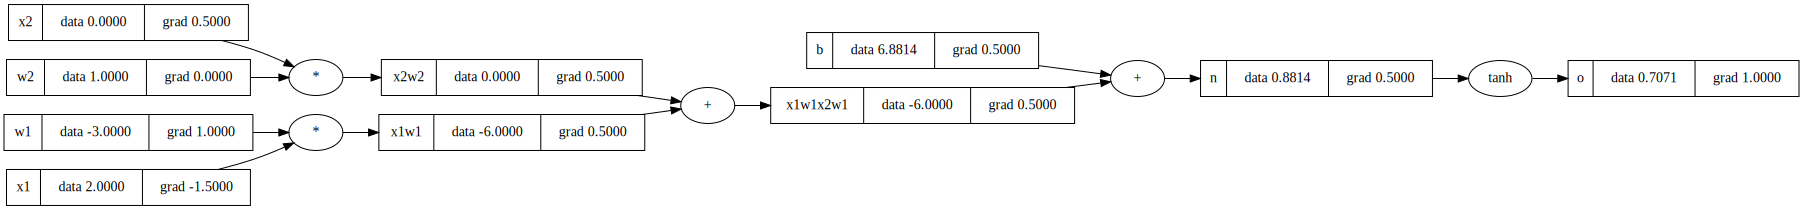

In [ ]:
## using the _backward method to do the backward pass

o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w1._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

In [48]:
## defining topological sort

topo = []
visited = set()

def topo_sort(v):
    if v not in visited:
        print(v)
        visited.add(v)
        for _child in v._prev:
            topo_sort(_child)
        topo.append(v)

topo_sort(o)
topo


Value: data(0.7071066671118554)
Value: data(0.8813733588701957)
Value: data(-6.0)
Value: data(-6.0)
Value: data(2.0)
Value: data(-3.0)
Value: data(0.0)
Value: data(0.0)
Value: data(1.0)
Value: data(6.881373358870196)


[Value: data(2.0),
 Value: data(-3.0),
 Value: data(-6.0),
 Value: data(0.0),
 Value: data(1.0),
 Value: data(0.0),
 Value: data(-6.0),
 Value: data(6.881373358870196),
 Value: data(0.8813733588701957),
 Value: data(0.7071066671118554)]